In [0]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/MyDrive/


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#import liraries
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

#others
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from tqdm import tqdm
import sqlite3
from sqlalchemy import create_engine
import datetime

#preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import cv2
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

## 1. Reading Data

In [0]:
df = pd.read_csv('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
print(df.shape)

(404290, 6)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

## 2.EDA

### 2.1 Distribution of data points based on output variable

In [0]:
df.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

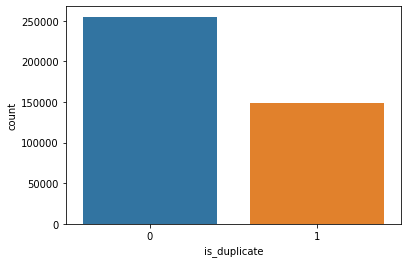

In [0]:
sns.countplot(x='is_duplicate', data =df)

### 2.2 Percentage of points where is_duplicate = 0 & 1

In [0]:
print(len(df[df['is_duplicate']==0]))
print(len(df[df['is_duplicate']==1]))
print(len(df[df['is_duplicate']==0]) + len(df[df['is_duplicate']==1]))
print(len(df))

255027
149263
404290
404290


In [0]:
print('Percentage of points where is_duplicate=0:',((len(df[df['is_duplicate']==0]))/ (len(df)))*100)
print('Percentage of points where is_duplicate=1:', ((len(df[df['is_duplicate']==1]))/(len(df)))*100)

Percentage of points where is_duplicate=0: 63.08021469737069
Percentage of points where is_duplicate=1: 36.9197853026293


### 2.3 Number of Unique question in dataset

In [0]:
#take qids on both questions and combine them and use 'set' to find unique qids
print('Total number of unique questions:', len(list(set(df['qid1'].tolist() + df['qid2'].tolist())))

537933

In [0]:
#unique qids that appear max than one time
print(pd.Series(df['qid1'].tolist() + df['qid2'].tolist()).value_counts())
print('Number of times a qid appears most:',max(pd.Series(df['qid1'].tolist() + df['qid2'].tolist()).value_counts()))

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64
Number of times a qid appears most: 157


In [0]:
print((pd.Series([1,2,3,3,4,4,5,6])).value_counts() > 1)
#to add number of True we use sum
print(sum((pd.Series([1,2,3,3,4,4,5,6])).value_counts() > 1))

4     True
3     True
6    False
5    False
2    False
1    False
dtype: bool
2


In [0]:
#number of unique qids that appear more than one time
sum(pd.Series(df['qid1'].tolist() + df['qid2'].tolist()).value_counts() > 1)

111780

### 2.4 Count plot for unique questions and repeated question

In [0]:
total_qids = len(df['qid1'].tolist() + df['qid2'].tolist())
no_unique_qids = len(list(set(df['qid1'].tolist() + df['qid2'].tolist())))
repeated_qids = total_qids - no_unique_qids

print(no_unique_qids)
print(repeated_qids)

537933
270647


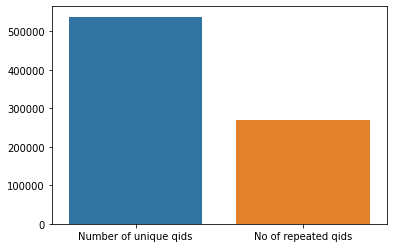

In [0]:
x =['Number of unique qids', 'No of repeated qids']
y = [no_unique_qids, repeated_qids]
sns.barplot(x,y)

### 2.5 Checking for Duplicates

In [0]:
pair_dupicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
pair_dupicates

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404285,537924,537925,1
404286,537926,537927,1
404287,537928,537929,1
404288,537930,537931,1


In [0]:
print('No of duplicates=', df.shape[0] - pair_dupicates.shape[0])

No of duplicates= 0


### 2.6 Number of occurences of each question

In [0]:
number_of_occurences_of_each_qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist()).value_counts()
print(number_of_occurences_of_each_qids)

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64


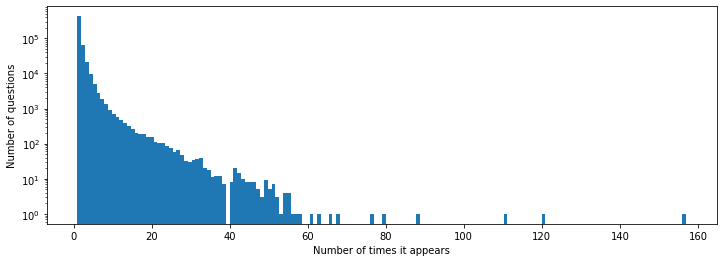

In [0]:
plt.figure(figsize=(12,4))
plt.hist(number_of_occurences_of_each_qids, bins=160)
plt.yscale('log')
plt.ylabel('Number of questions')
plt.xlabel('Number of times it appears')
plt.show()

### 2.7 Checking for Null values

In [0]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
#filling it with empty string
df = df.fillna('')

#looking it again
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [0]:
df.iloc[201841] # look at question2 and it fills with empty string

id                                        201841
qid1                                      303951
qid2                                      174364
question1       How can I create an Android app?
question2                                       
is_duplicate                                   0
Name: 201841, dtype: object

## 3.Basic Feature Extraction

In [0]:
#1. frequency of qid1
df.groupby('qid1')['qid1'].transform('count')

0          1
1          4
2          1
3          1
4          3
          ..
404285     2
404286    12
404287     1
404288     1
404289     1
Name: qid1, Length: 404290, dtype: int64

In [0]:
# frequency of qid2
df.groupby('qid2')['qid2'].transform('count')

0         1
1         1
2         1
3         1
4         1
         ..
404285    2
404286    1
404287    1
404288    1
404289    1
Name: qid2, Length: 404290, dtype: int64

In [0]:
# 2. length of question1 and question2 , here length includes space and individual chars
print(df['question1'].str.len())
print('='*50)
print(df['question2'].str.len())

0         66
1         51
2         73
3         50
4         76
          ..
404285    85
404286    41
404287    17
404288    94
404289    37
Name: question1, Length: 404290, dtype: int64
0          57
1          88
2          59
3          65
4          39
         ... 
404285     79
404286     42
404287     17
404288    127
404289     45
Name: question2, Length: 404290, dtype: int64


In [0]:
#3. number of words in each question
print(df['question1'].apply(lambda x: len(x.split(' '))))
print('='*50)
print(df['question2'].apply(lambda x: len(x.split(' '))))

0         14
1          8
2         14
3         11
4         13
          ..
404285    14
404286     8
404287     4
404288    17
404289     8
Name: question1, Length: 404290, dtype: int64
0         12
1         13
2         10
3          9
4          7
          ..
404285    13
404286     9
404287     3
404288    25
404289    10
Name: question2, Length: 404290, dtype: int64


In [0]:
# 4. number of common words in question1 and question2 for just first row
print(set(map(lambda x:x.lower().strip(), df['question1'][0].split(' '))))
print(set(map(lambda x:x.lower().strip() , df['question2'][0].split(' '))))
print('='*25, 'Common words in ques1 and ques2 in row1', '='*25)
set(map(lambda x:x.lower().strip(), df['question1'][0].split(' '))) & set(map(lambda x:x.lower().strip() , df['question2'][0].split(' ')))

{'what', 'step', 'by', 'is', 'share', 'invest', 'guide', 'the', 'market', 'india?', 'in', 'to'}
{'what', 'step', 'by', 'is', 'share', 'invest', 'guide', 'the', 'market?', 'in', 'to'}
========================= Common words in ques1 and ques2 in row1 =========================


{'by', 'guide', 'in', 'invest', 'is', 'share', 'step', 'the', 'to', 'what'}

In [0]:
# 5. total number of words in ques1 and ques2 for first row
print('Number of words in question1 in row1')
print(list(map(lambda x:x.lower().strip() ,df['question1'][0].split(' '))))
print(len(list(map(lambda x:x.lower().strip() ,df['question1'][0].split(' ')))))
print('='*50)
print('Number of words in question2 in row2')
print(list(map(lambda x: x.lower().strip(), df['question2'][0].split(' '))))
print(len(list(map(lambda x: x.lower().strip(), df['question2'][0].split(' ')))))

Number of words in question1 in row1
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india?']
14
Number of words in question2 in row2
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market?']
12


In [0]:
# 6. percentage of word share in row1 ==> number of common words/number of total words in row1
len(set(map(lambda x: x.lower().strip(), df['question1'][0].split(' '))) & set(map(lambda x: x.lower().strip(), df['question2'][0].split(' ')))) /(len(list(map(lambda x:x.lower().strip() ,df['question1'][0].split(' ')))) + len(list(map(lambda x: x.lower().strip(), df['question2'][0].split(' ')))))


0.38461538461538464

In [0]:
os.path.isfile('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/df_fe_without_preprocessing_train.csv')

True

In [0]:
# Function to accompany all these things
if os.path.isfile('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/df_fe_without_preprocessing_train.csv',encoding='latin-1')

else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.1 Data Analysis in extracted features

In [0]:
print('min number of words in a question1: ',min(df['q1_n_words']) )
print('min number of words in a question2: ',min(df['q2_n_words']) )
print('Number of question wiht min length [question1]: ', len(df[df['q1_n_words']==1]))
print('Number of question wiht min length [question2]: ', len(df[df['q2_n_words']==1]))

min number of words in a question1:  1
min number of words in a question2:  1
Number of question wiht min length [question1]:  67
Number of question wiht min length [question2]:  24


### 3.2 Featured word share

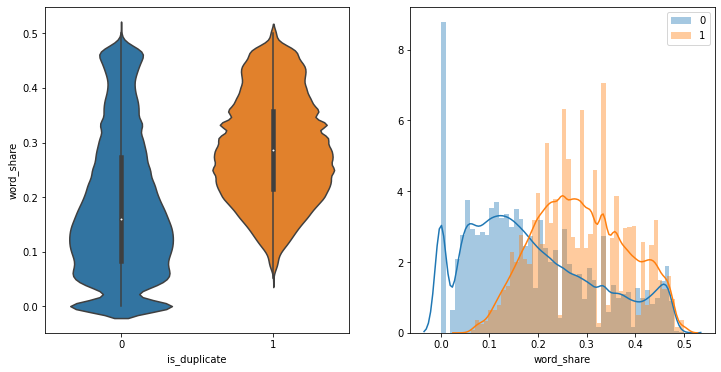

In [0]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_share', data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==0]['word_share'], label='0')
sns.distplot(df[df['is_duplicate']==1]['word_share'], label='1')
plt.legend()
plt.show()

### 3.3 Word common

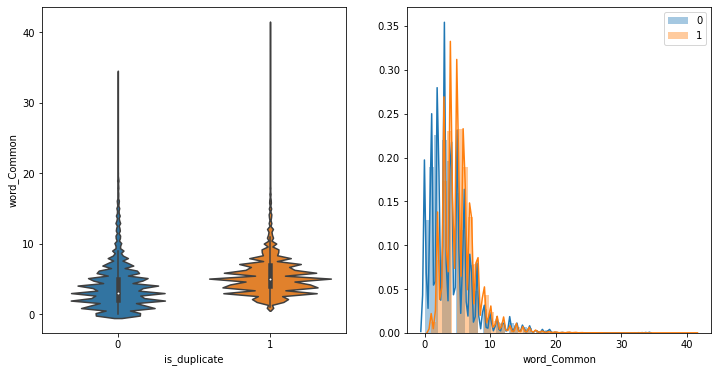

In [0]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==0]['word_Common'], label='0')
sns.distplot(df[df['is_duplicate']==1]['word_Common'], label='1')
plt.legend()
plt.show()

## 4.Preprocessing
- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [0]:
def preprocess(x):

    x = x.str.lower()

    #expanding contradictions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")

    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    #matches any non-alpha numeric a d substitue them with space ie ' ' 
    pattern = re.compile('\W')  
    if type(x)==type(''):
      x = re.sub(pattern, ' ',x)

    #stemming the words
    porter = PorterStemmer()
    
    if type(x)==type(''):
      x = porter.stem(x)
      example = BeautifulSoup(x)
      x = example.get_text()

    return x

## 5.Extracting fuzzy features:

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
print(len(set(['a','b','c']) & (set(['b','c', 'd']))))

2


In [0]:
Stop_Words = stopwords.words('english')
SAFE_DIV = 0.0001

def get_token_features(q1, q2):
    token_featues = [0.0]*10

    #split the questions into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if (q1_tokens==0) or (q2_tokens==0):
        return get_token_features

    #remove stop_words in question
    q1_words = set([i for i in q1_tokens if i not in Stop_Words])
    q2_words = set([i for i in q2_tokens if i not in Stop_Words])

    #get the stop words in question
    q1_stop_words = set([i for i in q1_tokens if i in Stop_Words])
    q2_stop_words = set([i for i in q2_tokens if i in Stop_Words])

    #get the common non_stop word from question
    common_word_count = len(q1_words & q2_words)

    #get the common stopword from question
    common_stop_word_count = len(q1_stop_words & q2_stop_words)

    #get the common token (ie before removing stop words)
    common_token_count = len(set(q1_tokens) & set(q2_tokens))

    token_feature[0] = common_word_count/(min(len(q1_words)&len(q2_words))+SAFE_DIV)
    token_feature[1] = common_word_count/max((len(q1_words)&len(q2_words))+SAFE_DIV)
    token_feature[2] = common_stop_word_count/(min(len(q1_stop_words)&len(q2_stop_words))+SAFE_DIV)
    token_feature[3] = common_stop_word_count/(max(len(q1_stop_words)&len(q2_stop_words))+SAFE_DIV)
    token_feature[4] = common_token_count/(min(len(q1_tokens)&len(q2_tokens))+SAFE_DIV)
    token_feature[5] = common_token_count/(max(len(q1_tokens)&len(q2_tokens))+SAFE_DIV)

    #last word of both question is same or not
    token_feature[6] = int(q1_tokens[-1] == q2_tokens[-1])

    #first word of both question is same or not
    token_feature[7] = int(q1_tokens[0] == q2_tokens[0])

    #difference bw lenght of two questions
    token_feature[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #average of length of two questions
    token_feature[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_feature

In [0]:
#check what distance.lcsubstrings return
print(list(distance.lcsubstrings('Kevin peterson', 'Alviron peterson'))[0])
print(len(list(distance.lcsubstrings('Kevin peterson', 'Alviron peterson'))[0]))

n peterson
10


In [0]:
#get the substring ratio
def get_longest_substring_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))

    if len(strs)==0:
        return 0

    else:
        return len(strs[0])/(min(len(a), len(b)) + 1)

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [0]:
os.path.exists('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/nlp_features_train.csv')

True

In [0]:
if os.path.isfile('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/nlp_features_train.csv'):
    df = pd.read_csv('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/nlp_features_train.csv',encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


## 6.Analysis of extracted Fuzzy features
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
print((np.dstack([['i am prem kumar'], ['i am a data scientist']]).flatten()))
print(len(np.dstack([['i am prem kumar'], ['i am a data scientist']]).flatten()))

['i am prem kumar' 'i am a data scientist']
2


In [0]:
df_duplicate = df[df['is_duplicate']==0]
df_nonduplicate = df[df['is_duplicate']==1]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

#no of data points in duplicate and non-duplicate
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 510054
Number of data points in class 0 (non duplicate pairs) : 298526


In [0]:
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [0]:
# reading the text files and removing the Stop Words:
textp_w = open('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/train_p.txt', encoding='latin-1').read()
textn_w = open('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/train_n.txt', encoding='latin-1').read()

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


### 6.1Word cloud

In [0]:
stop_words = set(Stop_Words)
stop_words.add("said")
stop_words.add("br")
stop_words.add(" ")

stop_words.remove("not")
stop_words.remove("no")

Word Cloud for Duplicate Question pairs


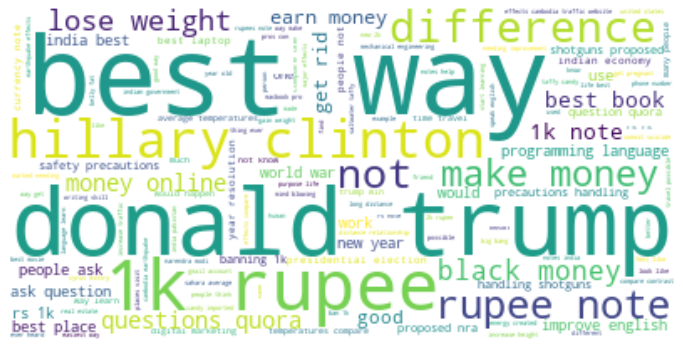

In [0]:
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stop_words)
wc.generate(textp_w)

plt.figure(figsize=(12,8))
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


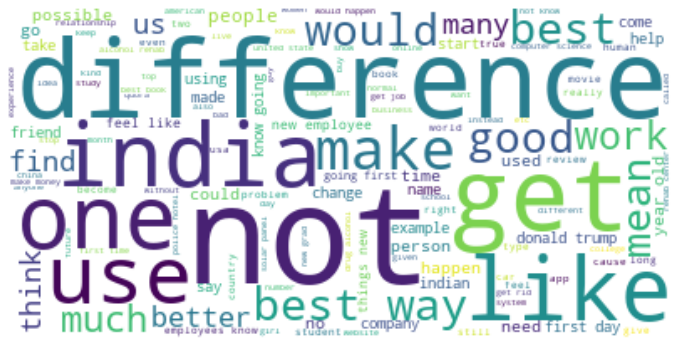

In [0]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stop_words)
wc.generate(textn_w)

plt.figure(figsize=(12,8))
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 6.2 Pair plot

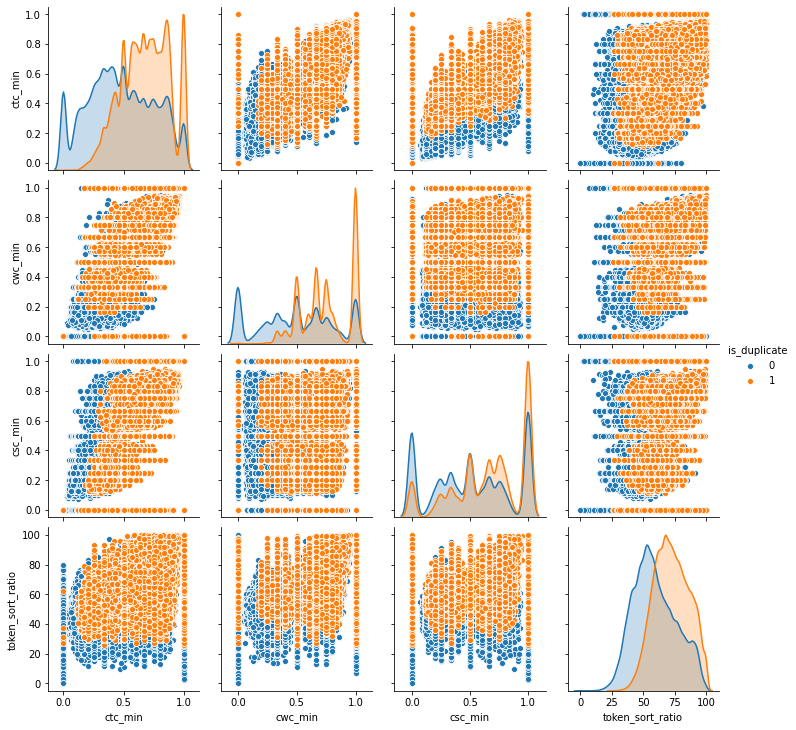

In [0]:
n = df.shape[0]

sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

### 6.3 Violin Plot

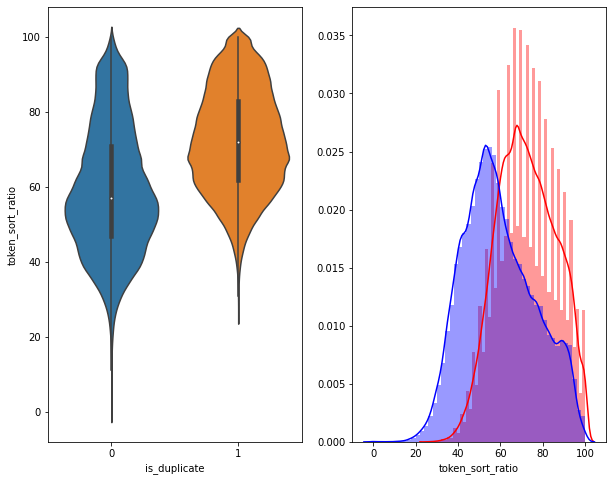

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

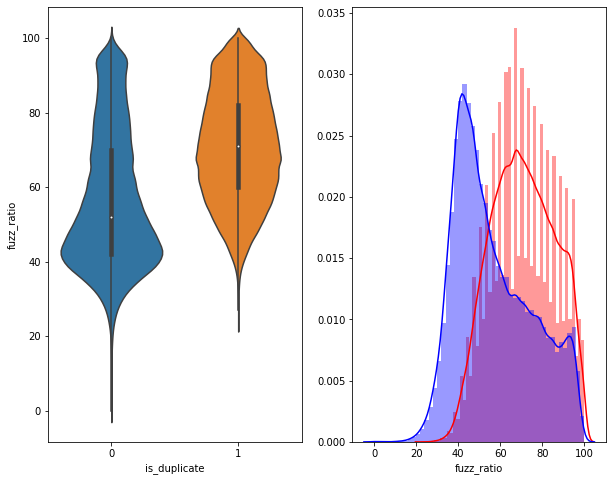

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## 7.Visualisation of features using t-SNE

In [0]:
#taking only sample of 5000 to visualize it
df_sampled = df[0:5000]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [0]:
X = MinMaxScaler().fit_transform(df_sampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df_sampled['is_duplicate'].values

### 7.1 t-SNE - 2D

In [0]:
tsne_2d = TSNE(n_components=2, init='random', random_state=42, method='barnes_hut', n_iter=1000, verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.391s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.315s
[t-SNE] Iteration 50: error = 82.2403336, gradient norm = 0.0485435 (50 iterations in 2.200s)
[t-SNE] Iteration 100: error = 70.3681030, gradient norm = 0.0092659 (50 iterations in 1.621s)
[t-SNE] Iteration 150: error = 68.5769806, gradient norm = 0.0058538 (50 iterations in 1.520s)
[t-SNE] Iteration 200: error = 67.7360840, gradient norm = 0.0040857 (50 iterations in 1.573s)
[t-SNE] Iteration 250: error = 67.2339020, gradient norm = 0.0052474

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


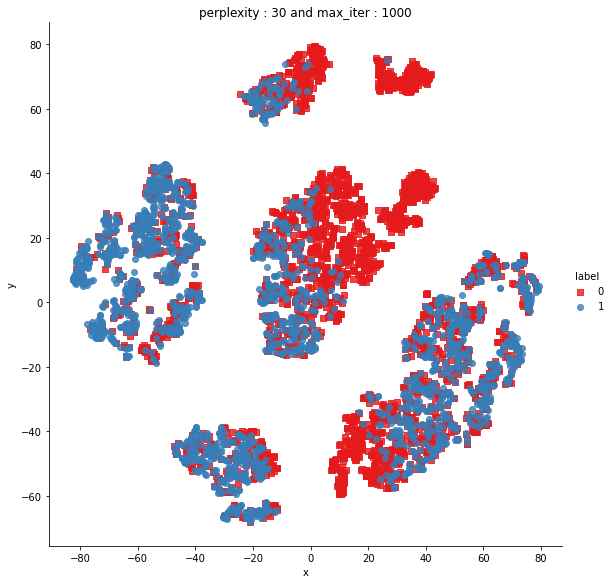

In [0]:
df_2d = pd.DataFrame({'x':tsne_2d[:,0], 'y':tsne_2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_2d, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

### 7.2 t-SNE - 3D

In [0]:
tsne_3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.310s
[t-SNE] Iteration 50: error = 80.3825836, gradient norm = 0.0316220 (50 iterations in 9.710s)
[t-SNE] Iteration 100: error = 69.1291580, gradient norm = 0.0034171 (50 iterations in 4.833s)
[t-SNE] Iteration 150: error = 67.6390839, gradient norm = 0.0017523 (50 iterations in 4.328s)
[t-SNE] Iteration 200: error = 67.0798187, gradient norm = 0.0011316 (50 iterations in 4.286s)
[t-SNE] Iteration 250: error = 66.7545319, gradient norm = 0.0010951

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
configure_plotly_browser_state()

trace1 = go.Scatter3d(
    x=tsne_3d[:,0],
    y=tsne_3d[:,1],
    z=tsne_3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')


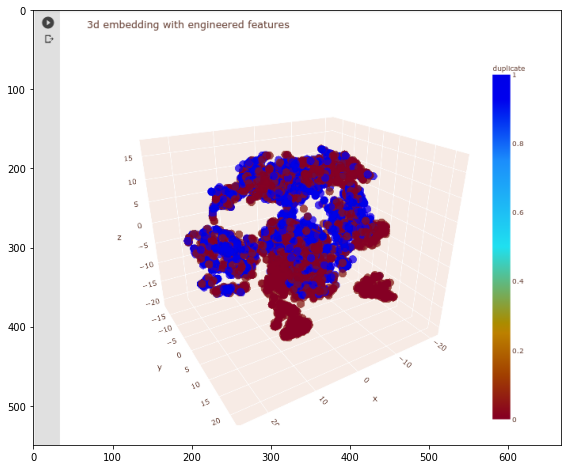

In [0]:
img = cv2.imread('/content/MyDrive/My Drive/Applied AI/Case studies/1. Quora/plotly-fig.png')

plt.figure(figsize=(12,8))
plt.imshow(img)

## 8. TFIDF-W2V 

In [4]:
df = pd.read_csv('/home/ubuntu/Quora/*Assign 22 -Quora/nlp_features_train.csv', encoding='latin-1')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [5]:
df['question1'] = df['question1'].apply(lambda x:str(x))
df['question2'] = df['question2'].apply(lambda x:str(x))

## **Note:**
- We need to apply tfidf weightedW2V on cleaned data (nlp_features_train.csv) rather than train.csv. 
- Also we need to split the data before applying tf-idf weighted W2V

In [6]:
#we need only questions1 and question2 and id to merge using it
df = df[['id', 'question1', 'question2', 'is_duplicate']]
df.head()

,id,question1,question2,is_duplicate
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


### 8.1 Splitting the data

In [7]:
print(df.shape)
print(df.iloc[:,-1:].shape)

(404290, 4)
(404290, 1)


In [8]:
df_train, df_val, y_train, y_val = train_test_split(df, df.iloc[:, -1:], test_size = 0.3, random_state=0 , stratify = df.iloc[:,-1:])
df_train, df_test, y_train, y_test = train_test_split(df_train, y_train, test_size= 0.3, random_state=0, stratify = y_train)

In [9]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(198102, 4)
(121287, 4)
(84901, 4)
(198102, 1)
(121287, 1)
(84901, 1)


In [16]:
df_train.head()

,id,question1,question2,is_duplicate
209577,209577,how do i use shall and should will and would ...,how do i use will and would in a sentence,0
17392,17392,is writing a good profession,can writing be a good profession,1
14251,14251,were there atheists in ancient mesopotamian ci...,were there atheists in ancient persia,0
265830,265830,has india really isolated pakistan globally i...,what do you think of russian troops arriving i...,0
123216,123216,which are the most visited temples of chhattis...,which are the most visited temples in chhattis...,1


In [17]:
df_val.head()

,id,question1,question2,is_duplicate
40373,40373,what is the name of the italian song goes some...,what is the title of the slow song that goes l...,0
218089,218089,what are some ways for you to lose 40 pounds i...,is it safe to lose 40 pounds in 2 weeks,1
184729,184729,what are some good ways to detoxify one own body,what are the most effective ways to detoxify y...,1
218907,218907,how many hours of deep sleep delta wave porti...,what is the ideal amount of sleep time that a ...,0
224215,224215,what are some important lesson you learn from ...,what are some important lessons you learned ou...,0


In [18]:
df_test.head()

,id,question1,question2,is_duplicate
372980,372980,how can i increase the traffic on my blog www...,how do i increase traffic on my site,1
14252,14252,what is the difference between pu leather and ...,are leather vans shoes made of real leather,0
102303,102303,which is correct 2 dozen of eggs cost 30 rup...,which one is correct 1 look out of the windo...,0
274316,274316,what are the best one liners,what are the best one liners in hindi,0
370597,370597,how can i start making money using internet,what is the easiest way to earn money using in...,1


### 8.2 IDF of words in questions

In [10]:
train_questions = df_train['question1'] + df_train['question2']
train_questions.head()

209577    how do i use shall and should  will and would ...
17392     is writing a good profession can writing be a ...
14251     were there atheists in ancient mesopotamian ci...
265830    has india really isolated pakistan globally  i...
123216    which are the most visited temples of chhattis...
dtype: object

In [19]:
vec = TfidfVectorizer(min_df = 25)
vec.fit_transform(train_questions)

#zip of (word, idf values of word)  and then dict it
word2tfidf = dict(zip(vec.get_feature_names(), vec.idf_))

In [20]:
len(word2tfidf)

7316

### Note:
- As said in email, i tried different min_df values of 10, 20, 25 and it gives 12.8k, 8.5k, and 7.3k respectively. I am using min_df = 25 for 2 reasons. First one is it reduces the dimension and the second one, the questions are almost similar to each other and the words in questions repeating again and again

In [21]:
#sum of all idf values which will be useful to find weighted_tfidf_w2v ==> ( (idf_w1*vec_w1) + (idf_w2*vec_w2) +...+(idf_wn*vec_wn))/(idf_w1+idf_w2+...+idf_wn)
#https://kite.com/python/answers/how-to-sum-the-values-in-a-dictionary-in-python#:~:text=Use%20sum()%20to%20sum,values%20from%20the%20previous%20step.

sum_idf = sum(word2tfidf.values())
print(sum_idf)

63219.72464508459


### 8.3 Loading glove in spacy

In [2]:
glove = spacy.load('en_core_web_sm')

print(glove)

In [16]:
#see what glove return when we given a sentence and its type
print(glove(df_train['question1'].iloc[0]))
print(type(glove(df_train['question1'].iloc[0])))

how do i use shall and should  will and would  can and could in a sentence 
<class 'spacy.tokens.doc.Doc'>


In [17]:
for i in glove(df_train['question1'].iloc[0]): #we dont need to split it and i.vector gives the vecotr representation of the word
    print((i, i.vector))
    print(len(i.vector))  #which gives dimension of each word

(how, array([-0.25642753, -1.651585  , -2.1492958 , -2.841151  , -0.38527584,
        2.9442854 ,  1.1803646 ,  0.25771916,  4.2077155 , -3.7638094 ,
        0.8159517 , -1.179973  , -1.6908273 , -0.77429676, -1.0198613 ,
        0.25888532,  2.2379441 , -2.775265  ,  2.6454005 , -3.402844  ,
       -0.8123921 ,  0.3909678 ,  1.4348501 ,  0.06442726, -0.08965635,
        0.06323573,  1.1758895 , -1.3840092 ,  1.2733849 , -0.3706682 ,
        8.229353  , -3.9226766 ,  3.9517229 ,  1.2850422 , -1.9552982 ,
       -3.0285926 ,  0.51044536,  1.8431818 ,  0.16051283,  5.5677285 ,
       -2.5549846 ,  2.0888383 , -4.9345465 ,  2.7583025 , -2.8520746 ,
        0.67331225, -1.9051372 , -1.1828032 , -3.6110253 ,  0.7943965 ,
       -1.1050334 ,  0.7351209 ,  7.117074  ,  0.3570062 ,  6.0055594 ,
        0.6539494 , -2.1824207 , -0.97305405,  0.886073  ,  0.5186693 ,
       -2.7837663 , -1.7447785 , -2.0322268 ,  2.2677383 ,  1.1464663 ,
       -0.67210156, -2.8589587 , -2.7366796 , -1.2349586 ,

### 8.4 Tfidf-W2V of training data

In [22]:
glove = spacy.load('en_core_web_sm')

X_train_question1_TfidfW2V = []

for row in tqdm(list(df_train['question1'].values)):
    doc1 = glove(row)       # it will return <class spacy.tokens.doc.Doc> which inclues word and its vector representation

    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))   # it returns the shape of length of the question we have(len(df_train['question1'].iloc[0])),  shape of vector representation of each word)
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]    # we are getting the idf value of word from word2tfidf which we found before

        except:
            idf = 0                       # if there is no such word found in word2tfidf put idf = 0 

        tfidf_vec += vec1 * idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_train_question1_TfidfW2V.append(tfidf_vec/sum_idf)


# For question2
X_train_question2_TfidfW2V = []
for row in tqdm(df_train['question2'].values):
    doc1 = glove(row)

    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]

        except:
            idf = 0

        tfidf_vec += vec1 * idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_train_question2_TfidfW2V.append(tfidf_vec/sum_idf)

100%|██████████| 198102/198102 [22:21<00:00, 147.72it/s]


In [23]:
(pd.DataFrame(list(X_train_question1_TfidfW2V), index=df_train.index)).head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
209577,-0.001408,0.000327,0.000356,-0.000416,0.001152,-0.000225,0.001099,0.000287,-0.000768,0.000180,...,-0.000187,-0.001495,-0.000674,-0.000012,0.000432,0.001797,-0.001833,0.000500,-0.000372,-0.000361
17392,-0.000344,0.000516,-0.000370,0.000124,0.000089,-0.000218,0.000848,0.000239,-0.000233,-0.000029,...,0.000256,-0.000107,-0.000330,0.000305,0.000280,-0.000936,-0.000229,0.001290,-0.000178,-0.000034
14251,0.000334,-0.000510,-0.000159,-0.000220,0.000479,0.000201,0.000521,0.000392,-0.000214,-0.000038,...,0.000050,-0.000384,0.000271,0.000616,0.000593,-0.000059,-0.000514,0.000086,-0.000243,-0.000370
265830,0.000964,-0.000363,-0.000142,-0.001105,0.000086,0.000750,0.002265,-0.000686,-0.001093,0.002652,...,-0.000203,-0.000720,-0.000117,0.000765,0.001610,-0.002756,-0.001085,0.001745,0.002341,0.000381
123216,0.000499,0.000644,0.000045,-0.000645,-0.000056,0.000088,0.000884,0.000917,0.000086,0.000066,...,0.000612,-0.001536,-0.000459,0.000266,-0.000111,-0.001080,-0.000151,0.000600,-0.000413,0.000340


In [24]:
#creating a new_df and store the values pf X_train_question1_TfidfW2V, X_train_question2_TfidfW2V
df1_train_q1 = pd.DataFrame(list(X_train_question1_TfidfW2V), index=df_train.index)
df1_train_q2 = pd.DataFrame(list(X_train_question2_TfidfW2V), index=df_train.index)
df1_train_q1['id'] = df_train['id']
df1_train_q2['id'] = df_train['id']

In [25]:
df1_train_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
209577,-0.001408,0.000327,0.000356,-0.000416,0.001152,-0.000225,0.001099,0.000287,-0.000768,0.000180,...,-0.001495,-0.000674,-0.000012,0.000432,0.001797,-0.001833,0.000500,-0.000372,-0.000361,209577
17392,-0.000344,0.000516,-0.000370,0.000124,0.000089,-0.000218,0.000848,0.000239,-0.000233,-0.000029,...,-0.000107,-0.000330,0.000305,0.000280,-0.000936,-0.000229,0.001290,-0.000178,-0.000034,17392
14251,0.000334,-0.000510,-0.000159,-0.000220,0.000479,0.000201,0.000521,0.000392,-0.000214,-0.000038,...,-0.000384,0.000271,0.000616,0.000593,-0.000059,-0.000514,0.000086,-0.000243,-0.000370,14251
265830,0.000964,-0.000363,-0.000142,-0.001105,0.000086,0.000750,0.002265,-0.000686,-0.001093,0.002652,...,-0.000720,-0.000117,0.000765,0.001610,-0.002756,-0.001085,0.001745,0.002341,0.000381,265830
123216,0.000499,0.000644,0.000045,-0.000645,-0.000056,0.000088,0.000884,0.000917,0.000086,0.000066,...,-0.001536,-0.000459,0.000266,-0.000111,-0.001080,-0.000151,0.000600,-0.000413,0.000340,123216


In [26]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_train_q1', 'wb') as f:
    pickle.dump(df1_train_q1, f)

In [27]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_train_q2', 'wb') as f:
    pickle.dump(df1_train_q2, f)

### 8.4 Tfidf-W2V of Validation data

In [28]:
X_val_question1_TfidfW2V = []

for row in tqdm(df_val['question1'].values):
    doc1 = glove(row)
    
    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]

        except:
            idf = 0

        tfidf_vec += vec1*idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_val_question1_TfidfW2V.append(tfidf_vec/sum_idf)


#for question2
X_val_question2_TfidfW2V = []

for row in tqdm(df_val['question2'].values):
    doc1 = glove(row)
    
    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]

        except:
            idf = 0

        tfidf_vec += vec1*idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_val_question2_TfidfW2V.append(tfidf_vec/sum_idf)

100%|██████████| 121287/121287 [13:41<00:00, 147.69it/s]


In [0]:
#df_val['q1_feat_m'] = list(X_val_question1_TfidfW2V) 
#df_val['q2_feat_m'] = list(X_val_question2_TfidfW2V)

In [29]:
#creating a new_df and store the values pf X_train_question1_TfidfW2V, X_train_question2_TfidfW2V
df1_val_q1 = pd.DataFrame(list(X_val_question1_TfidfW2V), index=df_val.index)
df1_val_q2 = pd.DataFrame(list(X_val_question2_TfidfW2V), index=df_val.index)

df1_val_q1['id'] = df_val['id']
df1_val_q2['id'] = df_val['id']

In [30]:
df1_val_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
40373,-0.000159,0.000458,-0.000402,-0.000483,0.000130,-0.000119,0.001170,0.001561,-0.000635,-0.000450,...,-0.000481,-0.000330,0.000607,0.000010,-0.000987,-0.001008,0.001416,-0.000206,0.001073,40373
218089,0.000898,-0.000156,-0.000911,-0.000556,-0.000303,0.000870,0.001503,0.002291,0.000382,-0.001005,...,-0.001964,0.000057,0.001166,0.000038,-0.000524,0.000722,0.000153,-0.000263,0.000021,218089
184729,0.000133,0.000457,-0.000055,-0.000310,0.000429,-0.000365,0.000877,0.001336,0.000402,-0.000686,...,-0.000902,-0.000764,-0.000128,-0.000147,-0.000776,0.000517,0.000409,-0.000460,0.000771,184729
218907,-0.000462,0.002448,0.001263,-0.001688,0.002052,-0.001278,0.001801,0.000822,0.000178,-0.000191,...,-0.003103,-0.002005,0.000140,0.000698,-0.000481,0.000438,0.001995,-0.000720,0.001984,218907
224215,-0.000054,0.000435,-0.000574,-0.000348,0.001170,0.000409,0.001567,0.001446,0.001041,0.000295,...,-0.001201,-0.000728,0.000339,0.000027,-0.000442,-0.000232,-0.000017,-0.000287,0.000959,224215


In [31]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_val_q1', 'wb') as f:
    pickle.dump(df1_val_q1, f)

In [32]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_val_q2', 'wb') as f:
    pickle.dump(df1_val_q2, f)

### 8.5 Tfidf-W2V of test data

In [33]:
X_test_question1_TfidfW2V = []

for row in tqdm(df_test['question1'].values):
    doc1 = glove(row)
    
    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]

        except:
            idf = 0

        tfidf_vec += vec1*idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_test_question1_TfidfW2V.append(tfidf_vec/sum_idf)


#for question2
X_test_question2_TfidfW2V = []

for row in tqdm(df_test['question2'].values):
    doc1 = glove(row)
    
    tfidf_vec = np.zeros((len(doc1), len(doc1[0].vector)))
    for word in doc1:
        vec1 = word.vector

        try:
            idf = word2tfidf[str(word)]

        except:
            idf = 0

        tfidf_vec += vec1*idf
    tfidf_vec = tfidf_vec.mean(axis=0)
    X_test_question2_TfidfW2V.append(tfidf_vec/sum_idf)

100%|██████████| 84901/84901 [09:38<00:00, 146.78it/s]


In [0]:
#df_test['q1_feat_m'] = list(X_test_question1_TfidfW2V) 
#df_test['q2_feat_m'] = list(X_test_question2_TfidfW2V)

In [34]:
#creating a new_df and store the values pf X_test_question1_TfidfW2V, X_test_question2_TfidfW2V
df1_test_q1 = pd.DataFrame(list(X_test_question1_TfidfW2V), index=df_test.index)
df1_test_q2 = pd.DataFrame(list(X_test_question2_TfidfW2V), index=df_test.index)

df1_test_q1['id'] = df_test['id']
df1_test_q2['id'] = df_test['id']

In [35]:
df1_test_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
372980,-0.000377,0.001172,-0.000138,-4.555279e-04,0.000465,-0.001193,0.001572,-0.000303,0.000256,0.000120,...,-0.001498,-0.000906,-0.000856,0.000429,-0.000876,0.000323,0.001183,-0.000154,0.001346,372980
14252,-0.000528,0.002283,0.001105,-4.036084e-04,0.000775,-0.000185,0.000425,0.001776,-0.000436,-0.000561,...,-0.000986,-0.001245,0.000111,-0.000159,-0.000798,0.000042,-0.000241,-0.000740,0.001334,14252
102303,0.000677,0.001573,-0.000833,-9.117768e-07,0.000431,0.000549,-0.000038,0.001381,-0.000317,-0.001411,...,-0.002414,-0.000285,0.001824,0.001346,-0.000581,0.002200,-0.000001,-0.001181,-0.000317,102303
274316,0.000050,0.000015,0.000009,-1.674369e-05,0.000129,-0.000316,0.000146,0.000182,0.000002,-0.000020,...,-0.000116,0.000231,0.000123,-0.000379,-0.000179,-0.000090,-0.000016,-0.000225,0.000041,274316
370597,-0.000573,0.000716,-0.000578,-3.668037e-04,0.000186,0.000074,0.001728,0.000995,-0.000444,0.000115,...,-0.001228,-0.000281,0.000514,0.000410,-0.000094,0.000316,0.001325,-0.000028,-0.000614,370597


In [36]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_test_q1', 'wb') as f:
    pickle.dump(df1_test_q1, f)

In [37]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/df1_test_q2', 'wb') as f:
    pickle.dump(df1_test_q2, f)

In [39]:
print(df1_train_q1.shape)
print(df1_train_q2.shape)
print(df1_val_q1.shape)
print(df1_val_q2.shape)
print(df1_test_q1.shape)
print(df1_test_q2.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(198102, 97)
(198102, 97)
(121287, 97)
(121287, 97)
(84901, 97)
(84901, 97)
(198102, 1)
(121287, 1)
(84901, 1)


### 8.6 Adding all the features to make the final dataframe
- df1   ==>tfidf_w2v_q1, tfidf_w2v_q2
- df2 ==> df_fe_without_preprocessing
- df3 ==>nlp_preprocessed

#### 8.6.1 df_fe_without_preprocessing

In [38]:
# 1. importing the df_fe_without_preprocessing
df2 = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
df2.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [40]:
df2.drop(labels=['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
df2.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [41]:
#Splitting it
df2_train, df2_val, y_train, y_val = train_test_split(df2, df.iloc[:, -1:], test_size=0.3, random_state=0, stratify = df.iloc[:,-1:])
df2_train, df2_test, y_train, y_test = train_test_split(df2_train, y_train, test_size=0.3, random_state=0, stratify = y_train)

In [42]:
print(df2_train.shape)
print(df2_test.shape)
print(y_train.shape)
print(y_test.shape)

(198102, 13)
(84901, 13)
(198102, 1)
(84901, 1)


In [43]:
df2_train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
209577,209577,0,4,2,75,46,16,10,8.0,24.0,0.333333,6,2
17392,17392,1,1,1,29,33,5,6,4.0,11.0,0.363636,2,0
14251,14251,0,1,1,58,38,7,6,5.0,13.0,0.384615,2,0
265830,265830,0,1,5,124,136,20,24,5.0,42.0,0.119048,6,4
123216,123216,1,1,1,51,51,8,8,7.0,16.0,0.437500,2,0


#### 8.6.2 NLP_features

In [47]:
# 2. importing nlp_features
df3 = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [48]:
df3.drop(labels=['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1, inplace=True)
df3.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [49]:
#Splitting it
df3_train, df3_val, y_train, y_val = train_test_split(df3, df.iloc[:, -1:], test_size=0.3, random_state=0, stratify=df.iloc[:, -1:])
df3_train, df3_test, y_train, y_test = train_test_split(df3_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [50]:
print(df3_train.shape)
print(df3_test.shape)
print(y_train.shape)
print(y_test.shape)

(198102, 16)
(84901, 16)
(198102, 1)
(84901, 1)


In [51]:
df3_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
209577,209577,0.999967,0.599988,0.999986,0.777769,0.999990,0.624996,1.0,1.0,6.0,13.0,100,73,72,70,0.319149
17392,17392,0.999967,0.999967,0.499975,0.333322,0.799984,0.666656,1.0,0.0,1.0,5.5,94,83,87,90,0.633333
14251,14251,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,0.0,1.0,1.0,6.5,90,74,74,87,0.794872
265830,265830,0.272725,0.249998,0.249997,0.199998,0.249999,0.208332,0.0,0.0,4.0,22.0,55,52,44,46,0.144000
123216,123216,0.999967,0.999967,0.799984,0.799984,0.874989,0.874989,1.0,1.0,0.0,8.0,97,94,96,96,0.673077


### 8.7 Merging all the features to make it one

In [52]:
df1_train_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
209577,-0.001408,0.000327,0.000356,-0.000416,0.001152,-0.000225,0.001099,0.000287,-0.000768,0.000180,...,-0.001495,-0.000674,-0.000012,0.000432,0.001797,-0.001833,0.000500,-0.000372,-0.000361,209577
17392,-0.000344,0.000516,-0.000370,0.000124,0.000089,-0.000218,0.000848,0.000239,-0.000233,-0.000029,...,-0.000107,-0.000330,0.000305,0.000280,-0.000936,-0.000229,0.001290,-0.000178,-0.000034,17392
14251,0.000334,-0.000510,-0.000159,-0.000220,0.000479,0.000201,0.000521,0.000392,-0.000214,-0.000038,...,-0.000384,0.000271,0.000616,0.000593,-0.000059,-0.000514,0.000086,-0.000243,-0.000370,14251
265830,0.000964,-0.000363,-0.000142,-0.001105,0.000086,0.000750,0.002265,-0.000686,-0.001093,0.002652,...,-0.000720,-0.000117,0.000765,0.001610,-0.002756,-0.001085,0.001745,0.002341,0.000381,265830
123216,0.000499,0.000644,0.000045,-0.000645,-0.000056,0.000088,0.000884,0.000917,0.000086,0.000066,...,-0.001536,-0.000459,0.000266,-0.000111,-0.001080,-0.000151,0.000600,-0.000413,0.000340,123216


In [53]:
df1_train_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,id
209577,-0.000420,0.000732,0.000223,0.000098,0.000457,-0.000188,0.000593,0.000071,-0.000114,-0.000216,...,-0.001276,-0.000195,-0.000072,0.000628,0.000981,-0.000501,-1.584456e-07,-0.000182,-0.000160,209577
17392,-0.000241,0.000540,-0.000648,-0.000138,-0.000073,-0.000196,0.000974,0.000221,-0.000201,0.000083,...,-0.000613,-0.000766,0.000038,-0.000008,-0.000362,-0.000098,9.235006e-04,-0.000313,0.000215,17392
14251,0.000454,-0.000384,-0.000364,-0.000215,0.000243,-0.000016,0.000652,0.000399,-0.000200,-0.000213,...,-0.000569,0.000327,0.000773,0.000408,0.000010,-0.000394,-3.209633e-05,-0.000169,-0.000161,14251
265830,0.000921,0.001301,-0.001152,-0.002585,0.001618,-0.000932,0.001984,0.001619,0.000762,0.000165,...,-0.001595,-0.001627,0.001314,-0.000161,-0.001513,-0.000807,2.333142e-03,0.000052,0.002449,265830
123216,0.000330,0.000452,-0.000152,-0.000489,-0.000366,0.000410,0.000901,0.000759,0.000181,0.000383,...,-0.001200,-0.000771,0.000372,-0.000030,-0.001093,-0.000116,5.760481e-04,-0.000340,0.000257,123216


In [54]:
df2_train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
209577,209577,0,4,2,75,46,16,10,8.0,24.0,0.333333,6,2
17392,17392,1,1,1,29,33,5,6,4.0,11.0,0.363636,2,0
14251,14251,0,1,1,58,38,7,6,5.0,13.0,0.384615,2,0
265830,265830,0,1,5,124,136,20,24,5.0,42.0,0.119048,6,4
123216,123216,1,1,1,51,51,8,8,7.0,16.0,0.437500,2,0


In [44]:
df3_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
209577,209577,0.999967,0.599988,0.999986,0.777769,0.999990,0.624996,1.0,1.0,6.0,13.0,100,73,72,70,0.319149
17392,17392,0.999967,0.999967,0.499975,0.333322,0.799984,0.666656,1.0,0.0,1.0,5.5,94,83,87,90,0.633333
14251,14251,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,0.0,1.0,1.0,6.5,90,74,74,87,0.794872
265830,265830,0.272725,0.249998,0.249997,0.199998,0.249999,0.208332,0.0,0.0,4.0,22.0,55,52,44,46,0.144000
123216,123216,0.999967,0.999967,0.799984,0.799984,0.874989,0.874989,1.0,1.0,0.0,8.0,97,94,96,96,0.673077


In [55]:
#merging all by id
df3_train = df3_train.merge(df2_train, on='id', how='left')
df3_train = df3_train.merge(df1_train_q1, on='id', how='left')
result_train = df3_train.merge(df1_train_q2, on='id', how='left')

df3_val = df3_val.merge(df2_val, on='id', how='left')
df3_val = df3_val.merge(df1_val_q1, on='id', how='left')
result_val = df3_val.merge(df1_val_q2, on='id', how='left')

df3_test = df3_test.merge(df2_test, on='id', how='left')
df3_test = df3_test.merge(df1_test_q1, on='id', how='left')
result_test = df3_test.merge(df1_test_q2, on='id', how='left')

In [56]:
result_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,209577,0.999967,0.599988,0.999986,0.777769,0.999990,0.624996,1.0,1.0,6.0,...,0.000075,-0.001276,-0.000195,-0.000072,0.000628,0.000981,-0.000501,-1.584456e-07,-0.000182,-0.000160
1,17392,0.999967,0.999967,0.499975,0.333322,0.799984,0.666656,1.0,0.0,1.0,...,0.000448,-0.000613,-0.000766,0.000038,-0.000008,-0.000362,-0.000098,9.235006e-04,-0.000313,0.000215
2,14251,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,0.0,1.0,1.0,...,0.000174,-0.000569,0.000327,0.000773,0.000408,0.000010,-0.000394,-3.209633e-05,-0.000169,-0.000161
3,265830,0.272725,0.249998,0.249997,0.199998,0.249999,0.208332,0.0,0.0,4.0,...,0.000124,-0.001595,-0.001627,0.001314,-0.000161,-0.001513,-0.000807,2.333142e-03,0.000052,0.002449
4,123216,0.999967,0.999967,0.799984,0.799984,0.874989,0.874989,1.0,1.0,0.0,...,0.000776,-0.001200,-0.000771,0.000372,-0.000030,-0.001093,-0.000116,5.760481e-04,-0.000340,0.000257


In [57]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/final_features_train', 'wb') as f:
    pickle.dump(result_train, f)

In [58]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/final_features_val', 'wb') as f:
    pickle.dump(result_val, f)

In [59]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/final_features_test', 'wb') as f:
    pickle.dump(result_test, f)

## 9. Saving it in sqlite db
- Since i have already finished the assignment of stackoverflow tag predictor and i worked with sqlite db there, i am here just saving it in db and i will only use the above final_features_train.csv, final_features_val.csv and final_features_test.csv

In [0]:
#creating train db using final_feature_train and storing those values in train_data table
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = datetime.datetime.now()
    chunk_size = 180000
    j = 0
    index_start = 1

    for df in pd.read_csv('final_features_train.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j += 1
        print('{] rows'.format(j*chunksize))
        df.tosql('train_data', disk_engine, if_exists='append')
        index_start = df.index[-1]+1 

In [0]:
#creating val db using final_feature_val and storing thoswe values in val_data table
if not os.path.isfile('val.db'):
    disk_engine = create_engine('sqlite:///val.db')
    start = datetime.datetime.now()
    chunk_size = 180000
    j = 0
    index_start = 1

    for df in pd.read_csv('final_features_val.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j += 1
        print('{] rows'.format(j*chunksize))
        df.tosql('val_data', disk_engine, if_exists='append')
        index_start = df.index[-1]+1 

In [0]:
#creating test db using final_feature_test and storing those values in test_data table
if not os.path.isfile('test.db'):
    disk_engine = create_engine('sqlite:///test.db')
    start = datetime.datetime.now()
    chunk_size = 180000
    j = 0
    index_start = 1

    for df in pd.read_csv('final_features_test.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j += 1
        print('{] rows'.format(j*chunksize))
        df.tosql('test_data', disk_engine, if_exists='append')
        index_start = df.index[-1]+1 

In [0]:
#creating a connection
def create_connection(db):
    conn = sqlite3.connect(db)
    return conn

def check_table_exists(conn):
    cursr = conn.cursor()
    str = 'SELECT name FROM sqlite_master WHERE type="table"'
    table_names = cursr.execute(str)
    tables = table_names.fetchall()
    print(tables)

In [0]:
#read the train.db
read_train_db = 'train.db'
conn_r = create_connection(read_train_db)
check_table_exists(conn_r)
conn_r.close()

#read the val.db
read_val_db = 'val.db'
conn_r = create_connection(read_val_db)
check_table_exists(conn_r)
conn_r.close()

#read the test.db
read_test_db = 'test.db'
conn_r = create_connection(read_test_db)
check_table_exists(conn_r)
conn_r.close()

In [0]:
#sampling only 700000 in train and 300000 in val as we already split it
def create_df(db, number)
    if os.path.isfile(db):
        conn_r = create_connection(db)

        if conn_r is not None:
            data = pd.read_sql_query('SELECT * FROM train_data LIMIT {}'.format(number), conn_r)
            conn_r.commit()
            conn_r.close()

In [0]:
#trainin_df
final_df_train = create_df(read_train_db, 700001)
final_df_val = create_df(read_val_db, 300001) 
final_df_test = create_df(read_test_db, 50001)

In [0]:
final_df_train.head()

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
final_df_val.head()

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
final_df_test.head()

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

### 8.8 Converting strings to Numerics

In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
def strings_to_numeric(df):
    cols = list(df.columns)
    for i in cols:
        df[i] = data[i].apply(pd.to_numeric)
        print(i)

In [0]:
final_train_df = strings_to_numeric(final_train_df)
final_var_df = strings_to_numeric(final_val_df)
final_test_df = strings_to_numeric(final_test_df)

## 10. Modelling

### 10.1 Creating confusion matrix

In [60]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### 10.2 Building a Random model

In [61]:
y_train = result_train['is_duplicate']
y_val = result_val['is_duplicate']
y_test = result_test['is_duplicate']

In [62]:
X_train = result_train.drop(labels='is_duplicate', axis=1, )
X_val = result_val.drop(labels='is_duplicate', axis=1)
X_test = result_test.drop(labels='is_duplicate', axis=1)

In [63]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(198102, 219)
(121287, 219)
(84901, 219)


In [64]:
X_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,209577,0.999967,0.599988,0.999986,0.777769,0.999990,0.624996,1.0,1.0,6.0,...,0.000075,-0.001276,-0.000195,-0.000072,0.000628,0.000981,-0.000501,-1.584456e-07,-0.000182,-0.000160
1,17392,0.999967,0.999967,0.499975,0.333322,0.799984,0.666656,1.0,0.0,1.0,...,0.000448,-0.000613,-0.000766,0.000038,-0.000008,-0.000362,-0.000098,9.235006e-04,-0.000313,0.000215
2,14251,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,0.0,1.0,1.0,...,0.000174,-0.000569,0.000327,0.000773,0.000408,0.000010,-0.000394,-3.209633e-05,-0.000169,-0.000161
3,265830,0.272725,0.249998,0.249997,0.199998,0.249999,0.208332,0.0,0.0,4.0,...,0.000124,-0.001595,-0.001627,0.001314,-0.000161,-0.001513,-0.000807,2.333142e-03,0.000052,0.002449
4,123216,0.999967,0.999967,0.799984,0.799984,0.874989,0.874989,1.0,1.0,0.0,...,0.000776,-0.001200,-0.000771,0.000372,-0.000030,-0.001093,-0.000116,5.760481e-04,-0.000340,0.000257


## Note:
- We are going to consider only 70k points for training and 30k points for validation bcoz of lack of computational power

In [65]:
X_train = X_train.iloc[0:70000,:]
y_train = y_train[0:70000]

X_val = X_val.iloc[0:30000,:]
y_val = y_val[0:30000]

In [66]:
print(X_train.shape)
print(y_train.shape)

(70000, 219)
(70000,)


Log loss for the random dummy model 16.152825637752038


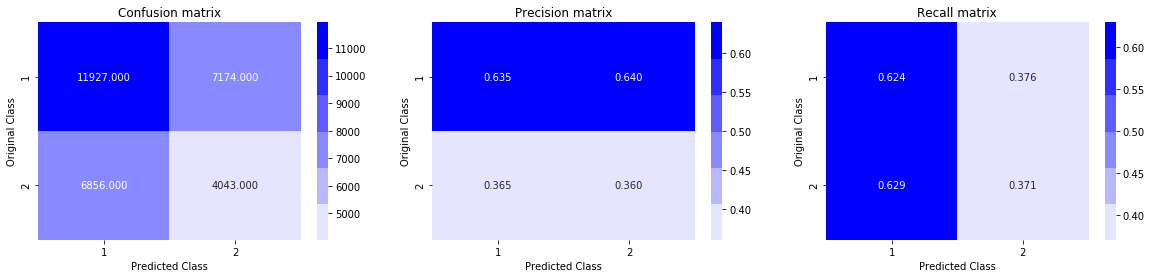

In [67]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)

print('Log loss for the random dummy model', log_loss(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

### 10.3 Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.6554000609637015
For values of alpha =  0.0001 The log loss is: 0.6554000609637015
For values of alpha =  0.001 The log loss is: 0.6554000609637015
For values of alpha =  0.01 The log loss is: 0.6554000609637015
For values of alpha =  0.1 The log loss is: 0.6554000609637015
For values of alpha =  1 The log loss is: 0.6464775961647082
For values of alpha =  10 The log loss is: 0.6314334520562241


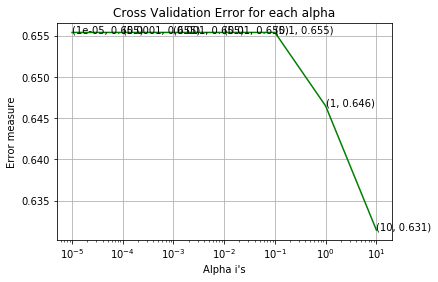

For values of best alpha =  10 The train log loss is: 0.6354490856754549
For values of best alpha =  10 The test log loss is: 0.6314334520562241
Total number of data points : 30000


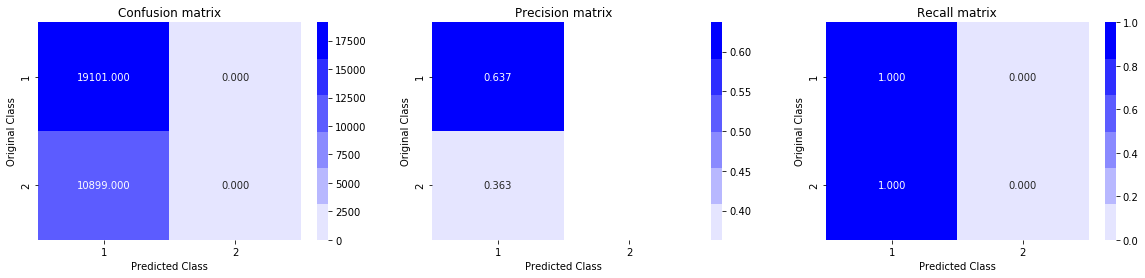

In [69]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_val)
    log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.xscale('log')
plt.show()


best_alpha = alpha[np.argmin(log_error_array)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_val)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_val, predicted_y)

### 10.4 XGBOOST

In [70]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train,y_train)

y_pred = xgb_clf.predict(X_val)
print('Log loss:', log_loss(y_val, y_pred, labels=xgb_clf.classes_, eps=1e-15))

Log loss: 5.892378127983023


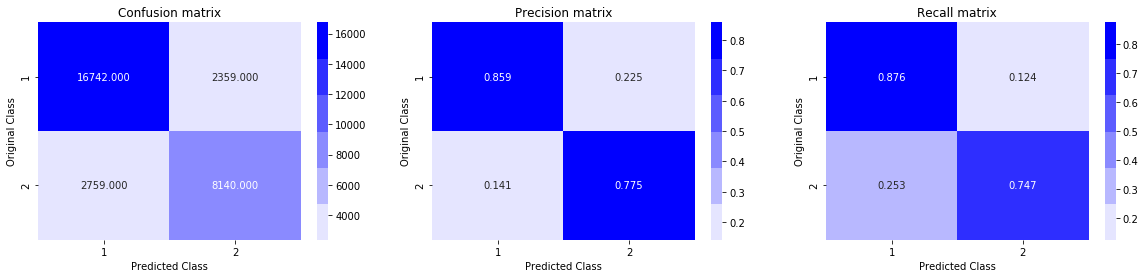

In [71]:
plot_confusion_matrix(y_val, y_pred)

# **12. TASK -2 :**
- Hyperparameter tuning of XGBOOST - Since it is computationally expensive i take only this three hyperparameters. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [72]:
from sklearn.model_selection import RandomizedSearchCV

In [73]:
XGB_clf = XGBClassifier()
params = {
          'learning_rate' : [0.01, 0.05, 0.1, 0.2],
          'n_estimators' : [100, 300, 500, 1000, 2000],
          'max_depth' : [3, 5, 10],
          'subsample' : [0.1, 0.3, 0.5, 1]
        }

random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, scoring='neg_log_loss', cv=2, return_train_score=True, n_jobs=-1 )

In [74]:
X_train.shape

(70000, 219)

In [75]:
random_search = random_search.fit(X_train, y_train)

In [76]:
random_search.best_params_

{'subsample': 1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05}

In [77]:
random_search.best_params_['n_estimators']

500

## Summary:

In [78]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'Best learning rate', 'Best n_estimators', 'Best max_depth', 'Best subsample']
x.add_row(['XGBoost', random_search.best_params_['learning_rate'], random_search.best_params_['n_estimators'], random_search.best_params_['max_depth'], random_search.best_params_['subsample']])
print(x)

+---------+--------------------+-------------------+----------------+----------------+
|  Model  | Best learning rate | Best n_estimators | Best max_depth | Best subsample |
+---------+--------------------+-------------------+----------------+----------------+
| XGBoost |        0.05        |        500        |       5        |       1        |
+---------+--------------------+-------------------+----------------+----------------+


# **11. TASK -1**
- Applying tfidf instead of tfidfw2v
- df2_train_q1 - tfidf for q1
- df2_train_q2 - tfidf for q2
- df2 ==> df_fe_without_preprocessing
- df3 ==>nlp_preprocessed

### 11.1 SPlittingt the dataset

In [ ]:
df_train, df_val, y_train, y_val = train_test_split(df, df.iloc[:, -1:], test_size = 0.3, random_state=0 , stratify = df.iloc[:,-1:])
df_train, df_test, y_train, y_test = train_test_split(df_train, y_train, test_size= 0.3, random_state=0, stratify = y_train)

### 11.2 Get the training questions

In [0]:
train_questions = df_train['question1'] + df_train['question2']
train_questions.head()

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor  koh i noor  dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely  how can i solve...
4    which one dissolve in water quikly sugar  salt...
dtype: object

### 11.3 TFIDF

In [84]:
vec = TfidfVectorizer(min_df=25)
vec.fit_transform(train_questions.values)

<198102x7316 sparse matrix of type '<class 'numpy.float64'>'
	with 2863942 stored elements in Compressed Sparse Row format>

In [85]:
pd.DataFrame.sparse.from_spmatrix(vec.transform(df_train['question1'].values), index = df_train.index)

,0,1,2,3,4,5,6,7,8,9,...,7306,7307,7308,7309,7310,7311,7312,7313,7314,7315
209577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
df2_train_q1 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_train['question1'].values), index= df_train.index)
df2_train_q2 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_train['question2'].values), index= df_train.index)

In [87]:
df2_train_q1['id'] = df_train['id']
df2_train_q2['id'] = df_train['id']
df2_train_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,7307,7308,7309,7310,7311,7312,7313,7314,7315,id
209577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209577
17392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17392
14251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14251
265830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265830
123216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123216


In [88]:
df2_val_q1 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_val['question1'].values), index=df_val.index)
df2_val_q2 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_val['question2'].values), index=df_val.index)

In [89]:
df2_val_q1['id'] = df_val['id']
df2_val_q2['id'] = df_val['id']
df2_val_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,7307,7308,7309,7310,7311,7312,7313,7314,7315,id
40373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40373
218089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218089
184729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184729
218907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218907
224215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224215


In [90]:
df2_test_q1 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_test['question1'].values), index=df_test.index)
df2_test_q2 = pd.DataFrame.sparse.from_spmatrix(vec.transform(df_test['question2'].values), index=df_test.index)

In [91]:
df2_test_q1['id'] = df_test['id']
df2_test_q2['id'] = df_test['id']
df2_test_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,7307,7308,7309,7310,7311,7312,7313,7314,7315,id
372980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372980
14252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14252
102303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102303
274316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274316
370597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,370597


## 11.4 Importing other dataframes

### 11.4.1 Importing df_fe_without_preprocessing

In [92]:
# 1. importing the df_fe_without_preprocessing
df2 = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
df2.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [93]:
df2.drop(labels=['qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
df2.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [94]:
#Splitting it
df2_train, df2_val, y_train, y_val = train_test_split(df2, df.iloc[:, -1:], test_size=0.3, random_state=0, stratify = df.iloc[:,-1:])
df2_train, df2_test, y_train, y_test = train_test_split(df2_train, y_train, test_size=0.3, random_state=0, stratify = y_train)

In [95]:
print(df2_train.shape)
print(df2_test.shape)
print(y_train.shape)
print(y_test.shape)

(198102, 13)
(84901, 13)
(198102, 1)
(84901, 1)


In [96]:
df2_train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
209577,209577,0,4,2,75,46,16,10,8.0,24.0,0.333333,6,2
17392,17392,1,1,1,29,33,5,6,4.0,11.0,0.363636,2,0
14251,14251,0,1,1,58,38,7,6,5.0,13.0,0.384615,2,0
265830,265830,0,1,5,124,136,20,24,5.0,42.0,0.119048,6,4
123216,123216,1,1,1,51,51,8,8,7.0,16.0,0.437500,2,0


### 11.4.2 NLP_features

In [97]:
# 2. importing nlp_features
df3 = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [98]:
df3.drop(labels=['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1, inplace=True)
df3.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [99]:
#Splitting it
df3_train, df3_val, y_train, y_val = train_test_split(df3, df.iloc[:, -1:], test_size=0.3, random_state=0, stratify=df.iloc[:, -1:])
df3_train, df3_test, y_train, y_test = train_test_split(df3_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [100]:
print(df3_train.shape)
print(df3_test.shape)
print(y_train.shape)
print(y_test.shape)

(198102, 16)
(84901, 16)
(198102, 1)
(84901, 1)


In [101]:
df3_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
209577,209577,0.999967,0.599988,0.999986,0.777769,0.999990,0.624996,1.0,1.0,6.0,13.0,100,73,72,70,0.319149
17392,17392,0.999967,0.999967,0.499975,0.333322,0.799984,0.666656,1.0,0.0,1.0,5.5,94,83,87,90,0.633333
14251,14251,0.666644,0.499988,0.999967,0.999967,0.833319,0.714276,0.0,1.0,1.0,6.5,90,74,74,87,0.794872
265830,265830,0.272725,0.249998,0.249997,0.199998,0.249999,0.208332,0.0,0.0,4.0,22.0,55,52,44,46,0.144000
123216,123216,0.999967,0.999967,0.799984,0.799984,0.874989,0.874989,1.0,1.0,0.0,8.0,97,94,96,96,0.673077


In [102]:
print(df2_train_q1.shape)
print(df2_train_q2.shape)
print(df2_train.shape)
print(df3_train.shape)
print('='*50)
print(df2_val_q1.shape)
print(df2_val_q2.shape)
print(df2_val.shape)
print(df3_val.shape)

(198102, 7317)
(198102, 7317)
(198102, 13)
(198102, 16)
(121287, 7317)
(121287, 7317)
(121287, 13)
(121287, 16)


In [103]:
#merging all by id
df3_train = df3_train.merge(df2_train, on='id', how='left')
df3_train = df3_train.merge(df2_train_q1, on='id', how='left')
assign_train = df3_train.merge(df2_train_q2, on='id', how='left')

df3_val = df3_val.merge(df2_val, on='id', how='left')
df3_val = df3_val.merge(df2_val_q1, on='id', how='left')
assign_val = df3_val.merge(df2_val_q2, on='id', how='left')

df3_test = df3_test.merge(df2_test, on='id', how='left')
df3_test = df3_test.merge(df2_test_q1, on='id', how='left')
assign_test = df3_test.merge(df2_test_q2, on='id', how='left')

In [104]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/assign_train', 'wb') as f:
    pickle.dump(assign_train, f)

In [105]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/assign_val', 'wb') as f:
    pickle.dump(assign_val, f)

In [106]:
import pickle
with open('/home/ubuntu/Quora/*Assign 22 -Quora/assign_test', 'wb') as f:
    pickle.dump(assign_test, f)

In [107]:
X_train = assign_train.iloc[0:70000,:]
X_val = assign_val.iloc[0:30000,:]

In [108]:
y_train = y_train[0:70000]
y_val = y_val[0:30000]

In [109]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print()

(70000, 14660)
(70000, 1)
(30000, 14660)
(30000, 1)



## 11.5 Modelling - Logistgic Regression

In [80]:
alpha = [10 ** i for i in range(-5, 4)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=0)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_val)
    log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.6554000609637015
For values of alpha =  0.0001 The log loss is: 0.6554000609637015
For values of alpha =  0.001 The log loss is: 0.6554000609637015
For values of alpha =  0.01 The log loss is: 0.6554000609637015
For values of alpha =  0.1 The log loss is: 0.6554000609637015
For values of alpha =  1 The log loss is: 0.6248822103768743
For values of alpha =  10 The log loss is: 0.6149182450360078
For values of alpha =  100 The log loss is: 0.6361725621636402
For values of alpha =  1000 The log loss is: 0.6447644179190515


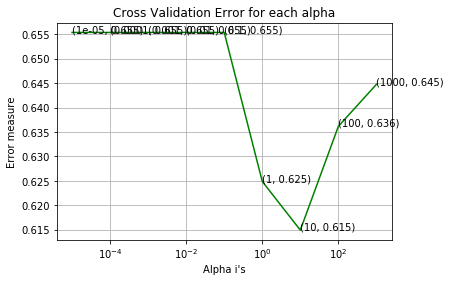

In [81]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.xscale('log')
plt.show()

For values of best alpha =  10 The train log loss is: 0.6354490856754549
For values of best alpha =  10 The test log loss is: 0.6314334520562241
Total number of data points : 30000


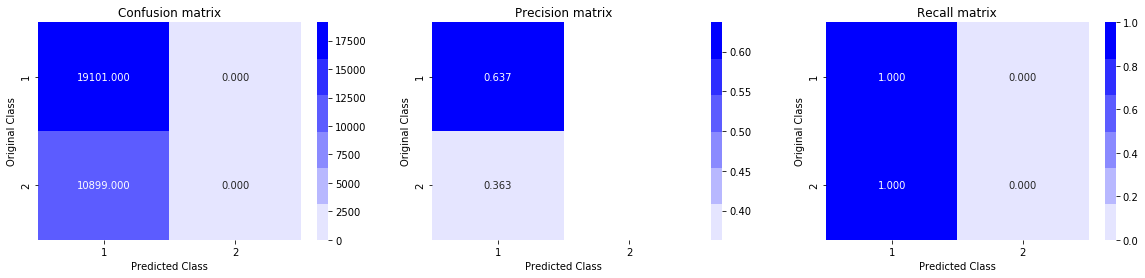

In [82]:
best_alpha = alpha[np.argmin(log_error_array)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_val)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_val, predicted_y)

# **Summary** 

In [83]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model', 'vectorizer','Best Alpha', 'Best Log loss']
x.add_row(['Logistic Regression', 'tfidf', best_alpha, 0.63078])
print(x)

+---------------------+------------+------------+---------------+
|        Model        | vectorizer | Best Alpha | Best Log loss |
+---------------------+------------+------------+---------------+
| Logistic Regression |   tfidf    |     10     |    0.63078    |
+---------------------+------------+------------+---------------+
